# Behavioral analysis of the SAflow MEG dataset

First, we need to compute the VTC (Variance Time Course) of every run.

In [35]:
import os
import os.path as op
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
from saflow.behav import *


def interpolate_RT(RT_raw):
    """Interpolates missing reaction times from the two nearest RTs.

    Parameters
    ----------
    RT_raw : np.array
        Raw reaction times as floats, with 0 for missing RT.

    Returns
    -------
    np.array
        The same array, but with 0s being replaced by the average of the two
        nearest RTs.

    """
    RT_array = RT_raw.copy()
    for idx, val in enumerate(RT_array):
        if val == 0:
            idx_next_val = 1
            try:
                while RT_array[idx + idx_next_val] == 0: # Find next non-zero value
                    idx_next_val += 1
                if idx == 0: # If first value is zero, use the next non-zero value
                    RT_array[idx] = RT_array[idx + idx_next_val]
                else: # else use the average of the two nearest non-zero
                    RT_array[idx] = RT_array[idx-1] + RT_array[idx + idx_next_val]
            except IndexError: # If end of file is reached, use the last non-zero
                RT_array[idx] = RT_array[idx-1]
    return RT_array

def compute_VTC(RT_array, subj_mean, subj_std):
    """Computes the raw (unfiltered) VTC.

    Parameters
    ----------
    RT_array : np.array
        Array of reaction times after interpolation.
    subj_mean : float
        Mean reaction time of a subject across all runs.
    subj_std : float
        Standard deviation of reaction times of a subject across all runs.

    Returns
    -------
    np.array
        Array containing VTC values, should be the same length as the RT array.

    """
    return abs((RT_array - subj_mean)/subj_std)

def old_compute_VTC(RT_interp, filt=True, filt_order=3, filt_cutoff=0.05):
    ### Compute the variance time course (VTC) of the array RT_interp
    VTC = (RT_interp - np.mean(RT_interp))/np.std(RT_interp)
    if filt == True:
        b, a = signal.butter(filt_order,filt_cutoff)
        VTC_filtered = signal.filtfilt(b, a, abs(VTC))
        VTC = VTC_filtered
    return VTC



def plot_VTC(ax, VTC_filtered, VTC_raw, IN_mask, OUT_mask, subject='?', bloc='?'):
    x = np.arange(0, len(VTC_raw))
    #fig = plt.figure()
    raw = ax.plot(x, VTC_raw)
    plt.setp(raw, linewidth=0.5, color='black')
    lines = ax.plot(x, IN_mask, x, OUT_mask)
    plt.setp(lines[0], linewidth=2, color='blue')
    plt.setp(lines[1], linewidth=2, color='orange')
    
    plt.legend(('VTC', 'IN zone', 'OUT zone'), loc='upper right')
    ax.set_title(f'VTC plot (sub-{subject}, run-0{bloc})')
    
    # TODO : add lapses and correct target detection

    return ax

def get_VTC_from_file(subject, run, files_list, cpt_blocs=[2,3,4,5,6,7], inout_bounds=[50,50]):
    # Find the logfiles belonging to a subject
    subject_logfiles = []
    for idx in range(len(cpt_blocs)):
        subject_logfiles.append(op.join(behav_path, find_logfile(subject, cpt_blocs[idx], files_list)))

    # Load and clean RT arrays
    RT_arrays = []
    for idx, logfile in enumerate(subject_logfiles):
        data = loadmat(logfile)
        df_response = pd.DataFrame(data['response'])
        RT_raw = np.asarray(df_response.loc[:,4])
        RT_interpolated = interpolate_RT(RT_raw)
        RT_arrays.append(RT_interpolated)
        if run == cpt_blocs[idx]:
            RT_to_VTC = RT_interpolated


    # Obtain meand and std across runs
    allruns_RT_array = np.concatenate(RT_arrays)
    subj_mean = np.mean(allruns_RT_array)
    subj_std = np.std(allruns_RT_array)
    
    # New VTC
    VTC_raw = compute_VTC(RT_to_VTC, subj_mean, subj_std)
    b, a = signal.butter(3, 0.05)#(filt_order,filt_cutoff)
    VTC_filtered = signal.filtfilt(b, a, VTC_raw)
    
    IN_mask = np.ma.masked_where(VTC_filtered >= np.quantile(VTC_filtered, bounds[0]/100), VTC_filtered)
    OUT_mask = np.ma.masked_where(VTC_filtered < np.quantile(VTC_filtered, bounds[1]/100), VTC_filtered)
    IN_idx = np.where(IN_mask.mask == False)[0]
    OUT_idx = np.where(OUT_mask.mask == False)[0]
    
    return IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask
    

In [36]:
behav_path = "/home/hyruuk/GitHub/cc_saflow/data/behav/"
files_list = os.listdir(behav_path)
cpt_blocs = [2,3,4,5,6,7]
subject = '23'
bounds = [25,75]


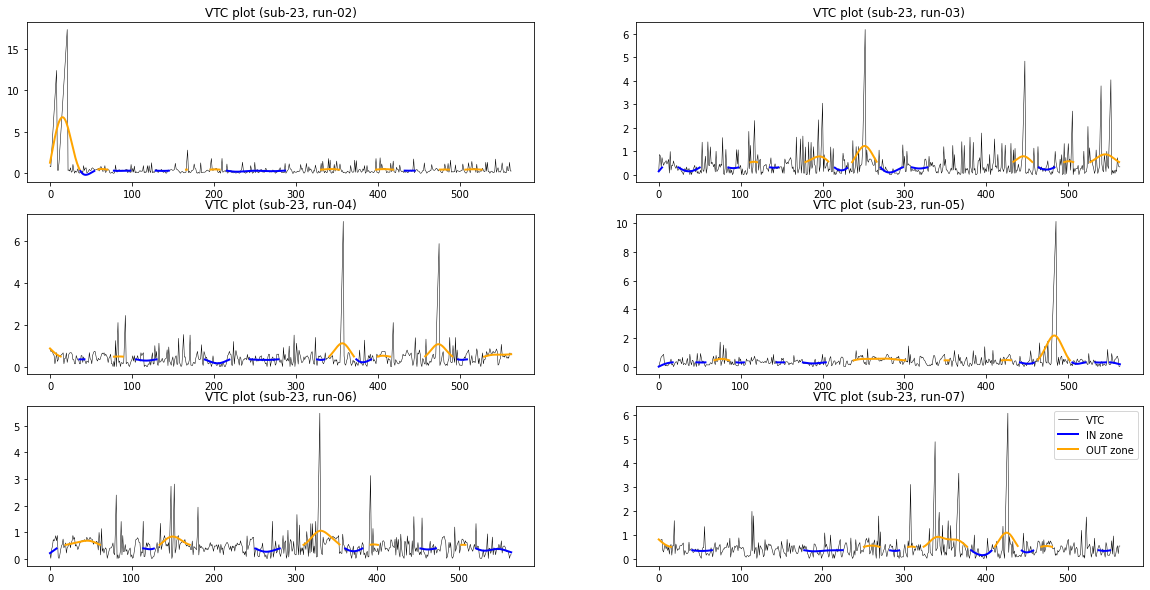

In [37]:
# Find the logfiles belonging to a subject
from saflow import SUBJECTS


fig, axes = plt.subplots(3,2, figsize=(20,10))
for idx, ax in enumerate(axes.flat):

    IN_idx, OUT_idx, VTC_raw, VTC_filtered, IN_mask, OUT_mask = get_VTC_from_file(subject, cpt_blocs[idx], files_list)
    ax = plot_VTC(ax, VTC_filtered, VTC_raw, IN_mask, OUT_mask, subject=subject, bloc=cpt_blocs[idx])



    


In [ ]:
len(IN_idx)

In [10]:
#RT_arrays[run-1]
new_compute_VTC(RT_arrays[run], subj_mean, subj_std)

NameError: name 'RT_arrays' is not defined

In [ ]:
run

In [ ]:
fig = new_plot_VTC(VTC_filtered, VTC_raw, IN_mask, OUT_mask)

In [ ]:
fig

In [ ]:
IN_mask = np.ma.masked_where(VTC_filtered < np.quantile(VTC_filtered, 25/100), VTC_filtered)

In [ ]:
np.quantile(VTC_filtered, 75/100)

In [ ]:
VTC_filtered < np.quantile(VTC_filtered, 25/100)